In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import numpy as np

In [2]:
# 한글 폰트 설치
!apt-get update -qq
!apt-get install -qq -y fonts-nanum

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [3]:
# 런타임 재시작 없이 폰트 적용
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

In [4]:
# 설치된 나눔 폰트 경로 찾기
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
fm.fontManager.addfont(font_path)  # 폰트 등록
plt.rc('font', family='NanumGothic')  # 기본 폰트 설정

In [5]:
!pip install dask[dataframe]

In [6]:
!pip install optuna

1. 파일 업로드 및 라이브러리 임포트

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import plotly.express as px
import optuna
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.impute import KNNImputer
import lightgbm as lgb
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')


train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/250223 부동산 허위매물 분류/dataset/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/250223 부동산 허위매물 분류/dataset/test.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/250223 부동산 허위매물 분류/dataset/sample_submission.csv')

In [8]:
print("Train data length:", len(train))
print("Test data length:", len(test))
print("Sample_submission data length:", len(sample_submission))

Train data length: 2452
Test data length: 613
Sample_submission data length: 613


2. EDA

In [9]:
train.head(5)

,ID,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일,허위매물여부
0,TRAIN_0000,현장확인,402500000.0,470000,NaN,NaN,15.0,서향,1.0,1.0,가능,40.0,96,t93Nt6I2I0,B플랫폼,2024-10-09,0
1,TRAIN_0001,현장확인,170500000.0,200000,NaN,3.0,4.0,남동향,2.0,1.0,불가능,NaN,0,q39iV5J4E6,D플랫폼,2024-12-26,0
2,TRAIN_0002,전화확인,114000000.0,380000,NaN,2.0,3.0,동향,1.0,1.0,불가능,NaN,0,b03oE4G3F6,A플랫폼,2024-11-28,0
3,TRAIN_0003,현장확인,163500000.0,30000,36.3,3.0,9.0,남동향,2.0,1.0,가능,13.0,10,G52Iz8V2B9,A플랫폼,2024-11-26,0
4,TRAIN_0004,현장확인,346000000.0,530000,NaN,3.0,3.0,동향,2.0,1.0,불가능,NaN,0,N45gM0M7R0,B플랫폼,2024-06-25,1


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      2452 non-null   object 
 1   매물확인방식  2452 non-null   object 
 2   보증금     2452 non-null   float64
 3   월세      2452 non-null   int64  
 4   전용면적    1665 non-null   float64
 5   해당층     2223 non-null   float64
 6   총층      2436 non-null   float64
 7   방향      2452 non-null   object 
 8   방수      2436 non-null   float64
 9   욕실수     2434 non-null   float64
 10  주차가능여부  2452 non-null   object 
 11  총주차대수   1756 non-null   float64
 12  관리비     2452 non-null   int64  
 13  중개사무소   2452 non-null   object 
 14  제공플랫폼   2452 non-null   object 
 15  게재일     2452 non-null   object 
 16  허위매물여부  2452 non-null   int64  
dtypes: float64(7), int64(3), object(7)
memory usage: 325.8+ KB


In [12]:
col_to_count = ['매물확인방식', '방향', '중개사무소', '제공플랫폼']
for col in col_to_count:
  print(train[col].value_counts())

매물확인방식
현장확인    1705
전화확인     382
서류확인     365
Name: count, dtype: int64
방향
남향     610
동향     605
서향     389
남동향    275
남서향    220
북향     198
북서향     80
북동향     75
Name: count, dtype: int64
중개사무소
G52Iz8V2B9    799
r82ax9M3U3     43
J52gJ2E4T6     32
H90uE4C0W5     30
b87Td0W4Y3     27
             ... 
c42uU9H5K7      1
z78FX7A1I1      1
G85Og3G9E9      1
V71Gz2X2C5      1
L27JO3N6S2      1
Name: count, Length: 279, dtype: int64
제공플랫폼
A플랫폼    958
B플랫폼    610
C플랫폼    350
D플랫폼    184
E플랫폼    142
F플랫폼     63
G플랫폼     59
H플랫폼     34
I플랫폼     20
J플랫폼     12
L플랫폼     10
K플랫폼      8
M플랫폼      2
Name: count, dtype: int64


# -> 결측치를 확인해본 결과, 해당층, 총층, 전용면적, 방수, 욕실수, 총주차대수에서 결측치가 관찰됨.

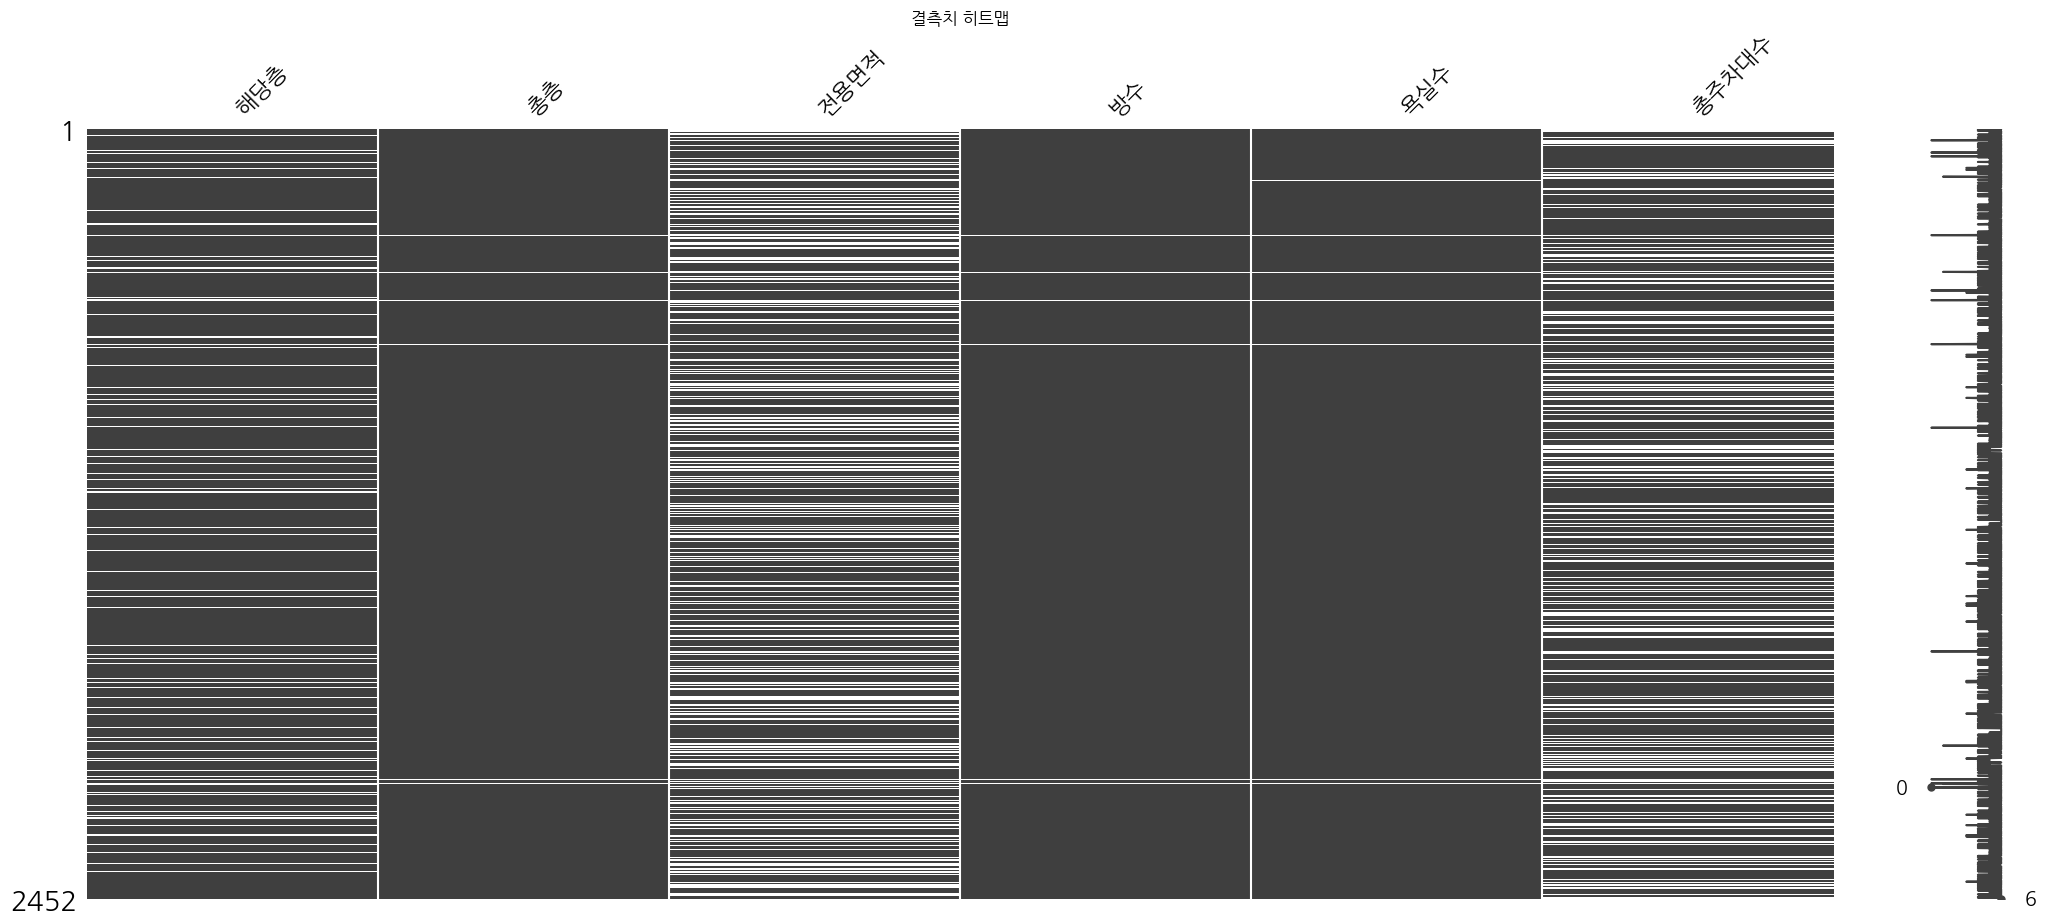

해당층      229
총층        16
전용면적     787
방수        16
욕실수       18
총주차대수    696
dtype: int64


In [11]:
import missingno as msno
msno.matrix(train[['해당층', '총층', '전용면적', '방수', '욕실수', '총주차대수']])
plt.title('결측치 히트맵')
plt.show()

print(train[['해당층', '총층', '전용면적', '방수', '욕실수', '총주차대수']].isnull().sum())

# -> 결측치 규칙성 없음

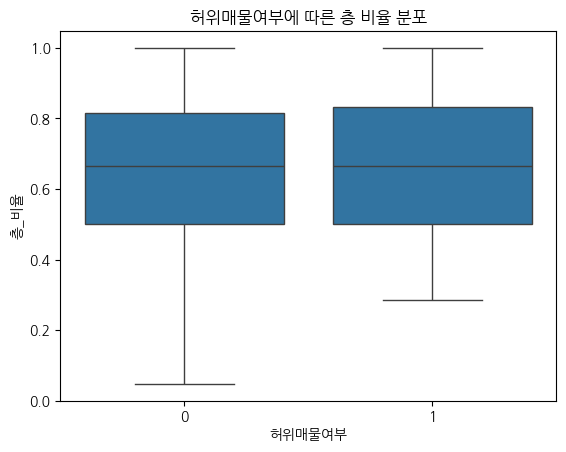

In [13]:
train['층_비율'] = train['해당층'] / (train['총층'] + 1e-5)
sns.boxplot(data=train, x='허위매물여부', y='층_비율')
plt.title('허위매물여부에 따른 층 비율 분포')
plt.show()

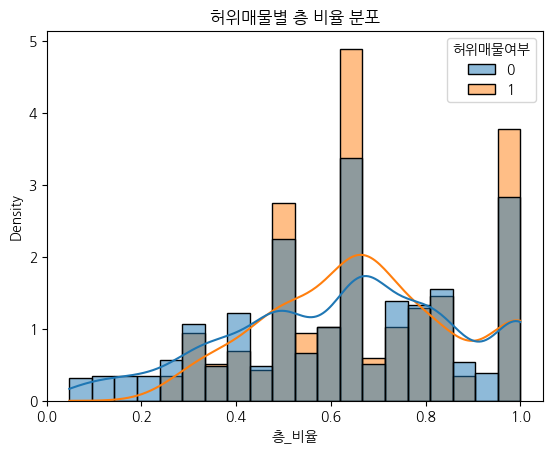

In [15]:
sns.histplot(data=train, x='층_비율', hue='허위매물여부', kde=True, stat="density", common_norm=False)
plt.title('허위매물별 층 비율 분포')
plt.show()

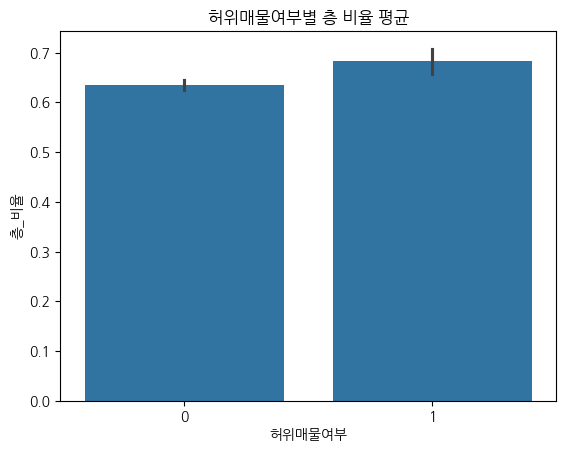

In [16]:
# 허위/정상 그룹별 층 비율 평균
sns.barplot(x='허위매물여부', y='층_비율', data=train)
plt.title('허위매물여부별 층 비율 평균')
plt.show()

-> 허위매물 그룹에서 상대적으로 층 비율이 높은 경향 확인됨

**- 허위매물의 경우 '좁은 공간에 과도한 방/욕실' 패턴이 발견되어 이를 반영한 변수 생성**

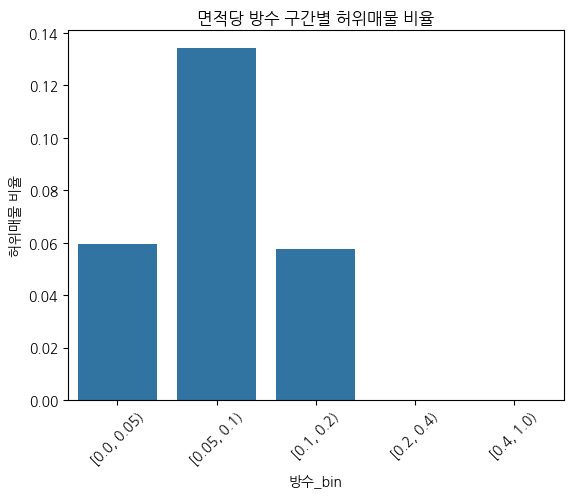

In [27]:
# 면적당_방수 구간화
train['방수_bin'] = pd.cut(train['면적당_방수'], bins=[0, 0.05, 0.1, 0.2, 0.4, 1.0], right=False)

# 구간별 허위매물 비율 계산
bin_summary = train.groupby('방수_bin')['허위매물여부'].mean().reset_index()

sns.barplot(x='방수_bin', y='허위매물여부', data=bin_summary)
plt.title('면적당 방수 구간별 허위매물 비율')
plt.xticks(rotation=45)
plt.ylabel('허위매물 비율')
plt.show()

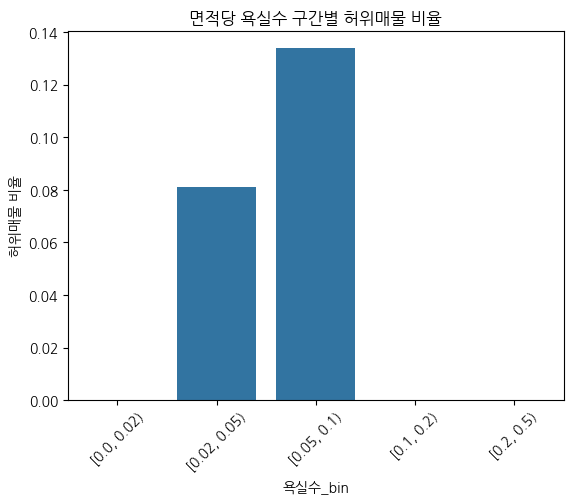

In [28]:
train['욕실수_bin'] = pd.cut(train['면적당_욕실수'], bins=[0, 0.02, 0.05, 0.1, 0.2, 0.5], right=False)

bin_summary2 = train.groupby('욕실수_bin')['허위매물여부'].mean().reset_index()

sns.barplot(x='욕실수_bin', y='허위매물여부', data=bin_summary2)
plt.title('면적당 욕실수 구간별 허위매물 비율')
plt.xticks(rotation=45)
plt.ylabel('허위매물 비율')
plt.show()

 - 단순 분포로는 패턴을 찾기 어렵다고 판단하여, 비율형 변수를 구간화 후 허위매물 비율을 직접 계산하여 확인

 - 특정 구간(예: 0.1 이상)부터 허위매물 비율이 높아지는 경향이 관찰

In [23]:
# 면적 대비 방수/욕실수 변수 생성
train['면적당_방수'] = train['방수'] / (train['전용면적'] + 1e-5)
train['면적당_욕실수'] = train['욕실수'] / (train['전용면적'] + 1e-5)

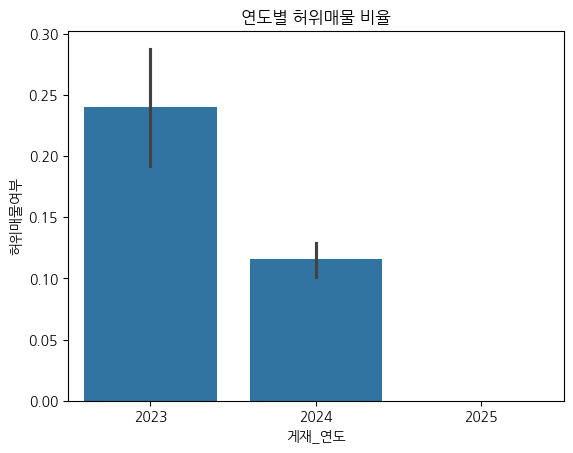

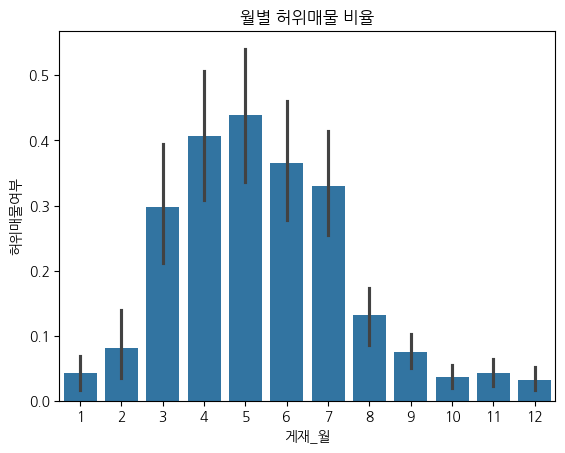

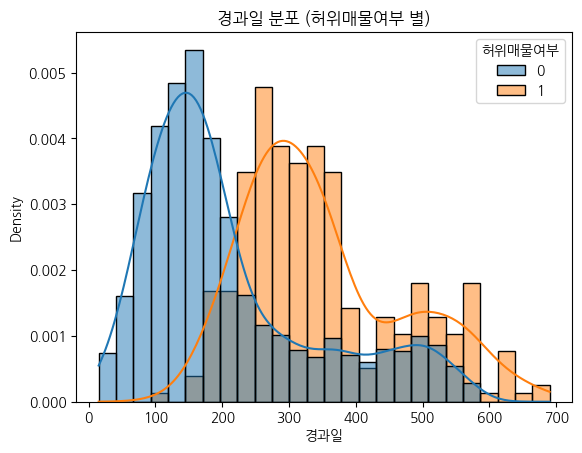

In [21]:
# 게재일 → 연도/월/일 추출
train['게재일'] = pd.to_datetime(train['게재일'])
train['게재_연도'] = train['게재일'].dt.year
train['게재_월'] = train['게재일'].dt.month

# 연도별 허위매물 비율
sns.barplot(x='게재_연도', y='허위매물여부', data=train)
plt.title('연도별 허위매물 비율')
plt.show()

# 월별 허위매물 비율
sns.barplot(x='게재_월', y='허위매물여부', data=train)
plt.title('월별 허위매물 비율')
plt.show()

# 추가: 실제 경과일의 분포
today = pd.to_datetime('today')
train['경과일'] = (today - train['게재일']).dt.days

sns.histplot(data=train, x='경과일', hue='허위매물여부', kde=True, stat="density", common_norm=False)
plt.title('경과일 분포 (허위매물여부 별)')
plt.show()

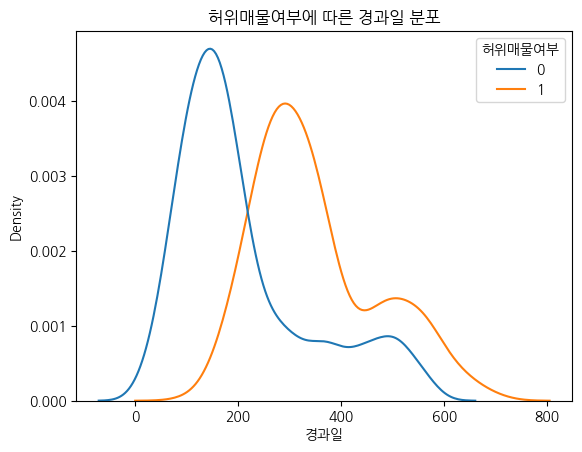

In [18]:
train['게재일'] = pd.to_datetime(train['게재일'])
today = pd.to_datetime('today')
train['경과일'] = (today - train['게재일']).dt.days

sns.kdeplot(data=train, x='경과일', hue='허위매물여부', common_norm=False)
plt.title('허위매물여부에 따른 경과일 분포')
plt.show()

-> 경과일이 오래된 매물에서 허위매물 비율이 다소 높게 나타남(연도 월 대비 규칙성 뚜렷)

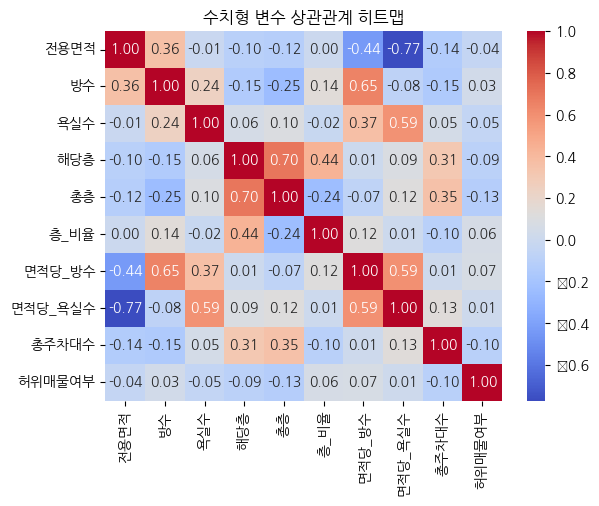

In [24]:
# 상관관계 히트맵
corr_cols = ['전용면적', '방수', '욕실수', '해당층', '총층',
             '층_비율', '면적당_방수', '면적당_욕실수', '총주차대수', '허위매물여부']

sns.heatmap(train[corr_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('수치형 변수 상관관계 히트맵')
plt.show()

 - 실제 허위매물 여부를 설명하는데 더 직관적이고 해석 가능한 층_비율, 면적당_방수, 면적당_욕실수 파생변수를 채택
 - 단순 수치형 변수(전용면적, 총층)보다 비율형 변수(면적당_방수, 층_비율)가 비정상 패턴을 더 잘 설명

1. 평균/중앙값 대체보다는 KNN Imputer로 주변 이웃의 패턴을 고려해 결측값 채우기
2. 범주형 변수의 경우 분류문제에서 사용 가능한 레이블 인코딩 적용
3. 허위매물일수록 고층 비율 높음
4. 면적대비 방수, 욕실수 특정 구간에서 허위매물 비율 높게 나타남
5. 경과일이 오래된 매물에서 허위매물 비율이 다소 높게 나타남

In [8]:
# 1. KNN 근접치 결측값 채우기 (해당층, 총층, 전용면적, 방수, 욕실수, 총주차대수)
knn_cols = ['해당층', '총층', '전용면적', '방수', '욕실수', '총주차대수']

imputer = KNNImputer(n_neighbors=5)
train[knn_cols] = imputer.fit_transform(train[knn_cols])
test[knn_cols] = imputer.transform(test[knn_cols])

# 2. 라벨 인코딩 (중개사무소, 제공플랫폼, 방향, 매물확인방식)
label_cols = ['중개사무소', '제공플랫폼', '방향', '매물확인방식']
for col in label_cols:
    le = LabelEncoder()
    combined = pd.concat([train[col], test[col]], axis=0).astype(str)
    le.fit(combined)
    train[col] = le.transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))

# 3. 층 비율 칼럼 추가 (해당층 / 총층)
train['층_비율'] = train['해당층'] / (train['총층'] + 1e-5)
test['층_비율'] = test['해당층'] / (test['총층'] + 1e-5)

# 4. 면적대비 방수, 욕실수 변수 추가
train['면적당_방수'] = train['방수'] / (train['전용면적'] + 1e-5)
train['면적당_욕실수'] = train['욕실수'] / (train['전용면적'] + 1e-5)
test['면적당_방수'] = test['방수'] / (test['전용면적'] + 1e-5)
test['면적당_욕실수'] = test['욕실수'] / (test['전용면적'] + 1e-5)

# 5. 부동산 경과일 변수 추가
train['게재일'] = pd.to_datetime(train['게재일'])
test['게재일'] = pd.to_datetime(test['게재일'])
today = pd.to_datetime('today')
train['경과일'] = (today - train['게재일']).dt.days
test['경과일'] = (today - test['게재일']).dt.days

# 6. 불필요한 컬럼 제거
drop_cols = ['방수', '욕실수', '방향', '주차가능여부', '해당층', '총층', '전용면적', '총주차대수', '게재일']
train.drop(columns=drop_cols, inplace=True, errors='ignore')
test.drop(columns=drop_cols, inplace=True, errors='ignore')

# 최종 확인
print(train.head())
print(test.head())

           ID  매물확인방식          보증금      월세  관리비  중개사무소  제공플랫폼  허위매물여부  \
0  TRAIN_0000       2  402500000.0  470000   96    256      1       0   
1  TRAIN_0001       2  170500000.0  200000    0    240      3       0   
2  TRAIN_0002       1  114000000.0  380000    0    157      0       0   
3  TRAIN_0003       2  163500000.0   30000   10     32      0       0   
4  TRAIN_0004       2  346000000.0  530000    0     76      1       1   

       층_비율    면적당_방수   면적당_욕실수  경과일  
0  0.640000  0.057143  0.057143  160  
1  0.749998  0.054060  0.027030   82  
2  0.666664  0.043825  0.043825  110  
3  0.333333  0.055096  0.027548  112  
4  0.999997  0.048785  0.024393  266  
         ID  매물확인방식          보증금      월세  관리비  중개사무소  제공플랫폼      층_비율  \
0  TEST_000       0  223000000.0  530000    7    151      3  0.999998   
1  TEST_001       0  150500000.0  590000   11     32      3  0.636363   
2  TEST_002       2   47000000.0  200000    0     76      1  0.666664   
3  TEST_003       0  133000000.0  2

In [9]:
print("Train data length:", len(train))
print("Test data length:", len(test))
print("Sample_submission data length:", len(sample_submission))

Train data length: 2452
Test data length: 613
Sample_submission data length: 613


In [10]:
train.head()

,ID,매물확인방식,보증금,월세,관리비,중개사무소,제공플랫폼,허위매물여부,층_비율,면적당_방수,면적당_욕실수,경과일
0,TRAIN_0000,2,402500000.0,470000,96,256,1,0,0.640000,0.057143,0.057143,160
1,TRAIN_0001,2,170500000.0,200000,0,240,3,0,0.749998,0.054060,0.027030,82
2,TRAIN_0002,1,114000000.0,380000,0,157,0,0,0.666664,0.043825,0.043825,110
3,TRAIN_0003,2,163500000.0,30000,10,32,0,0,0.333333,0.055096,0.027548,112
4,TRAIN_0004,2,346000000.0,530000,0,76,1,1,0.999997,0.048785,0.024393,266


In [11]:
# 컬럼명 확인
print(train.columns)

Index(['ID', '매물확인방식', '보증금', '월세', '관리비', '중개사무소', '제공플랫폼', '허위매물여부', '층_비율',
       '면적당_방수', '면적당_욕실수', '경과일'],
      dtype='object')


In [12]:
# 컬럼명을 리스트로 변환
print(train.columns.tolist())

['ID', '매물확인방식', '보증금', '월세', '관리비', '중개사무소', '제공플랫폼', '허위매물여부', '층_비율', '면적당_방수', '면적당_욕실수', '경과일']


In [13]:
columns_to_analyze = ['매물확인방식', '보증금', '월세', '관리비', '중개사무소', '제공플랫폼', '허위매물여부', '층_비율', '면적당_방수', '면적당_욕실수', '경과일']

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


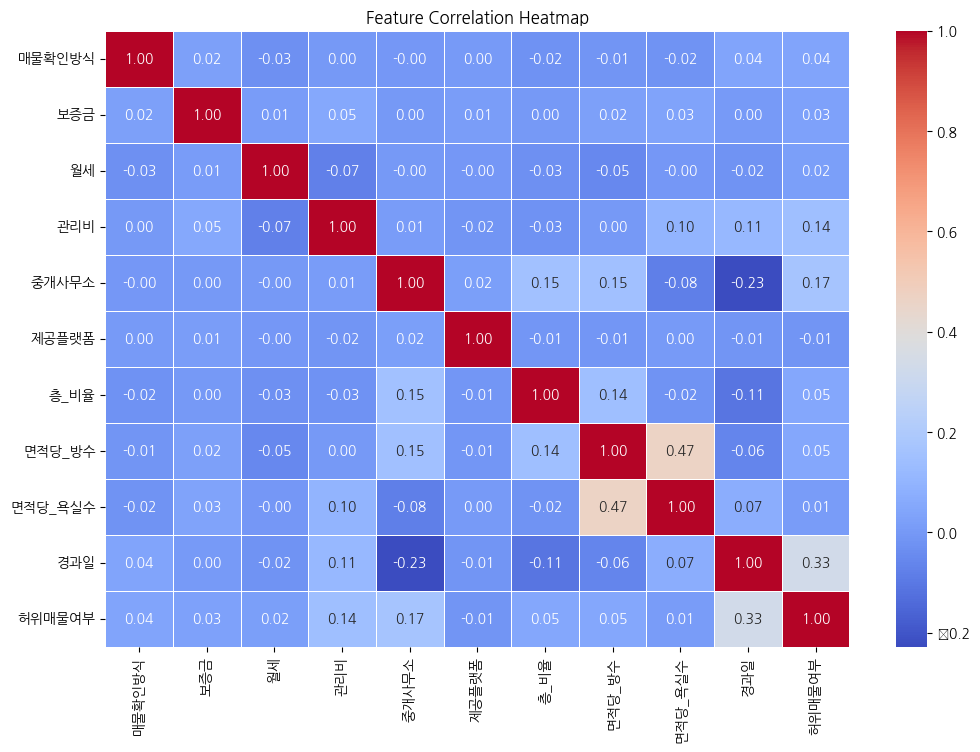

In [ ]:
# 히트맵을 위한 상관행렬 계산
plt.figure(figsize=(12, 8))
sns.heatmap(train[columns_to_analyze].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# **250318 메모**

1. 해당층, 총층, 전용면적, 방수, 욕실수, 총주차대수 KNN 근접치 결측값 채우기
2. 중개사무소, 제공플랫폼, 방향, 매물확인방식 라벨인코딩
3. 층 비율 칼럼 추가
4. 면적대비 방수, 욕실수 변수 추가
5. 부동산 경과일 변수 추가
6. '방수','욕실수','방향','주차가능여부','해당층','총층','전용면적','총주차대수' 칼럼을 제거

# **피쳐 엔지니어링**

In [14]:
# 컬럼명을 리스트로 변환
print(train.columns.tolist())

['ID', '매물확인방식', '보증금', '월세', '관리비', '중개사무소', '제공플랫폼', '허위매물여부', '층_비율', '면적당_방수', '면적당_욕실수', '경과일']


In [15]:
keep_cols = ['매물확인방식', '보증금', '월세', '관리비', '중개사무소', '제공플랫폼', '허위매물여부', '층_비율', '면적당_방수', '면적당_욕실수', '경과일']

train = train[keep_cols]

In [16]:
keep_cols_test = ['매물확인방식', '보증금', '월세', '관리비', '중개사무소', '제공플랫폼', '층_비율', '면적당_방수', '면적당_욕실수', '경과일']

test = test[keep_cols_test]

In [17]:
print(len(test), len(sample_submission))

613 613


3. Modeling

In [18]:
# 0. 데이터 준비
X = train.drop(columns=['허위매물여부'])
y = train['허위매물여부']

In [19]:
# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test)

In [20]:
# 1. SMOTE로 오버샘플링
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [21]:
# 2. Optuna로 하이퍼파라미터 튜닝 (예시: LGBM)
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }
    model = lgb.LGBMClassifier(**param, random_state=42)
    score = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='f1').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best LGB params:", study.best_params)

[I 2025-03-18 14:00:49,999] A new study created in memory with name: no-name-ce98dec5-a755-4321-bed7-25e3c80c779b


[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-03-18 14:00:51,298] Trial 0 finished with value: 0.9774643393306943 and parameters: {'n_estimators': 170, 'max_depth': 7, 'learning_rate': 0.10452157614781077, 'num_leaves': 114, 'min_child_samples': 48, 'subsample': 0.9421976501635336, 'colsample_bytree': 0.9125523918585582}. Best is trial 0 with value: 0.9774643393306943.


[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-03-18 14:00:53,575] Trial 1 finished with value: 0.9786861613470921 and parameters: {'n_estimators': 253, 'max_depth': 12, 'learning_rate': 0.07215691994469824, 'num_leaves': 58, 'min_child_samples': 63, 'subsample': 0.7846615731525507, 'colsample_bytree': 0.7759751703662758}. Best is trial 1 with value: 0.9786861613470921.


[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-03-18 14:00:55,589] Trial 2 finished with value: 0.9812954648083192 and parameters: {'n_estimators': 276, 'max_depth': 10, 'learning_rate': 0.0599142446473431, 'num_leaves': 34, 'min_child_samples': 70, 'subsample': 0.8401424197436016, 'colsample_bytree': 0.9020504882168762}. Best is trial 2 with value: 0.9812954648083192.


[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-03-18 14:00:57,752] Trial 3 finished with value: 0.9769832791589781 and parameters: {'n_estimators': 457, 'max_depth': 5, 'learning_rate': 0.13393336276089188, 'num_leaves': 120, 'min_child_samples': 11, 'subsample': 0.7007220810026418, 'colsample_bytree': 0.6693368480832393}. Best is trial 2 with value: 0.9812954648083192.


[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-03-18 14:01:00,383] Trial 4 finished with value: 0.9782312704270557 and parameters: {'n_estimators': 133, 'max_depth': 13, 'learning_rate': 0.09242768899922738, 'num_leaves': 74, 'min_child_samples': 28, 'subsample': 0.9164541928087414, 'colsample_bytree': 0.9632695222975394}. Best is trial 2 with value: 0.9812954648083192.


[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-03-18 14:01:03,904] Trial 5 finished with value: 0.9789966738597394 and parameters: {'n_estimators': 343, 'max_depth': 11, 'learning_rate': 0.05555124983634085, 'num_leaves': 74, 'min_child_samples': 86, 'subsample': 0.8668139506320297, 'colsample_bytree': 0.8618399130944632}. Best is trial 2 with value: 0.9812954648083192.


[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-03-18 14:01:04,938] Trial 6 finished with value: 0.9748396837776789 and parameters: {'n_estimators': 143, 'max_depth': 15, 'learning_rate': 0.0537488418243501, 'num_leaves': 120, 'min_child_samples': 95, 'subsample': 0.5266170048302016, 'colsample_bytree': 0.9297826796341164}. Best is trial 2 with value: 0.9812954648083192.


[LightGBM] [Info] Number of positive: 1723, number of negative: 1724
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2380
[LightGBM] [Info] Number of data points in the train set: 3447, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499855 -> initscore=-0.000580
[LightGBM] [Info] Start training from score -0.000580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-03-18 14:01:08,228] Trial 7 finished with value: 0.9792051814497942 and parameters: {'n_estimators': 247, 'max_depth': 13, 'learning_rate': 0.08239497299600178, 'num_leaves': 67, 'min_child_samples': 34, 'subsample': 0.6471142649637995, 'colsample_bytree': 0.8618934628931398}. Best is trial 2 with value: 0.9812954648083192.


[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2379
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, t

[I 2025-03-18 14:01:09,310] Trial 8 finished with value: 0.9791034216051981 and parameters: {'n_estimators': 176, 'max_depth': 14, 'learning_rate': 0.19102224047636246, 'num_leaves': 23, 'min_child_samples': 57, 'subsample': 0.6630254627928717, 'colsample_bytree': 0.8266416537798625}. Best is trial 2 with value: 0.9812954648083192.


[LightGBM] [Info] Number of positive: 1723, number of negative: 1724
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2380
[LightGBM] [Info] Number of data points in the train set: 3447, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499855 -> initscore=-0.000580
[LightGBM] [Info] Start training from score -0.000580
[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2025-03-18 14:01:10,537] Trial 9 finished with value: 0.9772115203075117 and parameters: {'n_estimators': 242, 'max_depth': 6, 'learning_rate': 0.13835849103909034, 'num_leaves': 26, 'min_child_samples': 55, 'subsample': 0.617378236933481, 'colsample_bytree': 0.6618544561556836}. Best is trial 2 with value: 0.9812954648083192.


[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-03-18 14:01:12,417] Trial 10 finished with value: 0.9792661272473522 and parameters: {'n_estimators': 370, 'max_depth': 9, 'learning_rate': 0.19932552017813587, 'num_leaves': 43, 'min_child_samples': 76, 'subsample': 0.8174600536667642, 'colsample_bytree': 0.5015917001834371}. Best is trial 2 with value: 0.9812954648083192.


[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-03-18 14:01:15,790] Trial 11 finished with value: 0.9717704083405065 and parameters: {'n_estimators': 382, 'max_depth': 9, 'learning_rate': 0.018854646057165705, 'num_leaves': 45, 'min_child_samples': 79, 'subsample': 0.7986337522784899, 'colsample_bytree': 0.6040552134221048}. Best is trial 2 with value: 0.9812954648083192.


[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-03-18 14:01:18,331] Trial 12 finished with value: 0.9779307505890678 and parameters: {'n_estimators': 427, 'max_depth': 9, 'learning_rate': 0.18160829160557343, 'num_leaves': 43, 'min_child_samples': 77, 'subsample': 0.9960417181038659, 'colsample_bytree': 0.5020441178390823}. Best is trial 2 with value: 0.9812954648083192.


[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-03-18 14:01:20,259] Trial 13 finished with value: 0.9783546378229602 and parameters: {'n_estimators': 333, 'max_depth': 8, 'learning_rate': 0.14657231410529614, 'num_leaves': 97, 'min_child_samples': 74, 'subsample': 0.8401748878752084, 'colsample_bytree': 0.5200241725100851}. Best is trial 2 with value: 0.9812954648083192.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-18 14:01:23,340] Trial 14 finished with value: 0.9742988466553386 and parameters: {'n_estimators': 490, 'max_depth': 10, 'learning_rate': 0.01788214558319124, 'num_leaves': 143, 'min_child_samples': 95, 'subsample': 0.7378895899576304, 'colsample_bytree': 0.7422996260022132}. Best is trial 2 with value: 0.9812954648083192.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-18 14:01:26,126] Trial 15 finished with value: 0.9784391733184382 and parameters: {'n_estimators': 380, 'max_depth': 11, 'learning_rate': 0.04506867973711325, 'num_leaves': 44, 'min_child_samples': 67, 'subsample': 0.83980721052211, 'colsample_bytree': 0.6064949956254457}. Best is trial 2 with value: 0.9812954648083192.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-03-18 14:01:28,849] Trial 16 finished with value: 0.9798952799968432 and parameters: {'n_estimators': 293, 'max_depth': 8, 'learning_rate': 0.16327993095237825, 'num_leaves': 33, 'min_child_samples': 44, 'subsample': 0.9079274877900141, 'colsample_bytree': 0.9968064671901805}. Best is trial 2 with value: 0.9812954648083192.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-18 14:01:31,428] Trial 17 finished with value: 0.9791092869106132 and parameters: {'n_estimators': 290, 'max_depth': 7, 'learning_rate': 0.1705475284446905, 'num_leaves': 21, 'min_child_samples': 41, 'subsample': 0.9080471875723682, 'colsample_bytree': 0.9948552078819662}. Best is trial 2 with value: 0.9812954648083192.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing

[I 2025-03-18 14:01:34,232] Trial 18 finished with value: 0.9808143435908322 and parameters: {'n_estimators': 285, 'max_depth': 8, 'learning_rate': 0.13351800450079515, 'num_leaves': 87, 'min_child_samples': 23, 'subsample': 0.9886405027548645, 'colsample_bytree': 0.8957614506580226}. Best is trial 2 with value: 0.9812954648083192.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-18 14:01:37,116] Trial 19 finished with value: 0.9802890738796982 and parameters: {'n_estimators': 201, 'max_depth': 11, 'learning_rate': 0.12183342359188937, 'num_leaves': 90, 'min_child_samples': 18, 'subsample': 0.9915682021437606, 'colsample_bytree': 0.8029133233798438}. Best is trial 2 with value: 0.9812954648083192.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-18 14:01:38,911] Trial 20 finished with value: 0.9763694256947865 and parameters: {'n_estimators': 214, 'max_depth': 5, 'learning_rate': 0.1133987041568249, 'num_leaves': 105, 'min_child_samples': 22, 'subsample': 0.9471201798333941, 'colsample_bytree': 0.8888361228364611}. Best is trial 2 with value: 0.9812954648083192.


[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-03-18 14:01:43,366] Trial 21 finished with value: 0.9800888966950435 and parameters: {'n_estimators': 206, 'max_depth': 11, 'learning_rate': 0.1180571406943211, 'num_leaves': 84, 'min_child_samples': 16, 'subsample': 0.9901436889266707, 'colsample_bytree': 0.802533769359936}. Best is trial 2 with value: 0.9812954648083192.


[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-03-18 14:01:47,381] Trial 22 finished with value: 0.9781742206238089 and parameters: {'n_estimators': 272, 'max_depth': 12, 'learning_rate': 0.12351485240943313, 'num_leaves': 92, 'min_child_samples': 30, 'subsample': 0.9749588967933099, 'colsample_bytree': 0.8343812138793538}. Best is trial 2 with value: 0.9812954648083192.


[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-03-18 14:01:49,976] Trial 23 finished with value: 0.9800953202572211 and parameters: {'n_estimators': 319, 'max_depth': 10, 'learning_rate': 0.15665262151427053, 'num_leaves': 85, 'min_child_samples': 10, 'subsample': 0.8809513627052756, 'colsample_bytree': 0.7532477351603951}. Best is trial 2 with value: 0.9812954648083192.


[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

[I 2025-03-18 14:01:53,372] Trial 24 finished with value: 0.9777718504939539 and parameters: {'n_estimators': 188, 'max_depth': 10, 'learning_rate': 0.09725137792061245, 'num_leaves': 133, 'min_child_samples': 21, 'subsample': 0.7532836556032232, 'colsample_bytree': 0.9361703743906319}. Best is trial 2 with value: 0.9812954648083192.


[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-03-18 14:01:55,641] Trial 25 finished with value: 0.9764326341028268 and parameters: {'n_estimators': 224, 'max_depth': 8, 'learning_rate': 0.03460911449133445, 'num_leaves': 58, 'min_child_samples': 39, 'subsample': 0.9519894899538988, 'colsample_bytree': 0.892995469353811}. Best is trial 2 with value: 0.9812954648083192.


[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-03-18 14:01:58,338] Trial 26 finished with value: 0.9794239606512498 and parameters: {'n_estimators': 103, 'max_depth': 12, 'learning_rate': 0.12918934993143985, 'num_leaves': 101, 'min_child_samples': 21, 'subsample': 0.8779218667475506, 'colsample_bytree': 0.7066568313738537}. Best is trial 2 with value: 0.9812954648083192.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 34

[I 2025-03-18 14:02:01,052] Trial 27 finished with value: 0.9772480155580817 and parameters: {'n_estimators': 274, 'max_depth': 7, 'learning_rate': 0.07913709665621313, 'num_leaves': 77, 'min_child_samples': 51, 'subsample': 0.9597912582091556, 'colsample_bytree': 0.8054348336212673}. Best is trial 2 with value: 0.9812954648083192.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-18 14:02:04,195] Trial 28 finished with value: 0.9789575467238469 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.06675275903525263, 'num_leaves': 59, 'min_child_samples': 63, 'subsample': 0.9955220631098165, 'colsample_bytree': 0.8577868614797123}. Best is trial 2 with value: 0.9812954648083192.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-18 14:02:05,888] Trial 29 finished with value: 0.9787437479889196 and parameters: {'n_estimators': 154, 'max_depth': 9, 'learning_rate': 0.09564118796959895, 'num_leaves': 111, 'min_child_samples': 49, 'subsample': 0.5235316022985594, 'colsample_bytree': 0.9109664805034117}. Best is trial 2 with value: 0.9812954648083192.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [22]:
# 3. 모델 정의 (튜닝된 LGBM + XGB + RFC)
lgb_best = lgb.LGBMClassifier(**study.best_params, random_state=42)
xgb_model = xgb.XGBClassifier(n_estimators=300, max_depth=10, learning_rate=0.05, subsample=0.8, random_state=42)
rf_model = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_split=5, random_state=42)

In [23]:
# 4. 소프트 보팅 앙상블
voting_clf = VotingClassifier(estimators=[
    ('lgb', lgb_best),
    ('xgb', xgb_model),
    ('rf', rf_model)
], voting='soft', n_jobs=-1)

In [24]:
# 5. KFold 교차검증 및 평가지표 확인
kf = KFold(n_splits=5, shuffle=True, random_state=42)

acc_scores = []
f1_scores = []
roc_auc_scores = []

for train_idx, val_idx in kf.split(X_resampled):
    X_train, X_val = X_resampled[train_idx], X_resampled[val_idx]
    y_train, y_val = y_resampled[train_idx], y_resampled[val_idx]

    voting_clf.fit(X_train, y_train)
    y_pred = voting_clf.predict(X_val)
    y_proba = voting_clf.predict_proba(X_val)[:, 1]

    acc_scores.append(accuracy_score(y_val, y_pred))
    f1_scores.append(f1_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_proba))

print(f'Accuracy 평균: {np.mean(acc_scores):.4f}')
print(f'F1 평균: {np.mean(f1_scores):.4f}')
print(f'ROC-AUC 평균: {np.mean(roc_auc_scores):.4f}')

Accuracy 평균: 0.9770
F1 평균: 0.9772
ROC-AUC 평균: 0.9964


In [25]:
# 6. 최종 모델 학습 후 테스트 데이터 예측
voting_clf.fit(X_resampled, y_resampled)
test_pred = voting_clf.predict(test_scaled)

5. 제출파일 생성

In [26]:
# 7. 제출파일 생성
sample_submission['허위매물여부'] = test_pred
sample_submission.to_csv('250318_submission_voting.csv', index=False, encoding='utf-8-sig')

In [27]:
# 8. 분류 리포트 출력 (SMOTE 후 전체 데이터)
print("\n[Classification Report on Full Train]")
y_full_pred = voting_clf.predict(X_resampled)
print(classification_report(y_resampled, y_full_pred))


[Classification Report on Full Train]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2154
           1       1.00      1.00      1.00      2154

    accuracy                           1.00      4308
   macro avg       1.00      1.00      1.00      4308
weighted avg       1.00      1.00      1.00      4308

